# Lesson 5: Quantum-Inspired Filter

In this notebook, we’ll explore quantum-inspired filters for image processing, specifically focusing on their application in precise image segmentation tasks. Quantum-inspired methods leverage quantum mechanics’ mathematical framework to design algorithms that, while executed on classical hardware, can outperform traditional classical methods. By using concepts such as quantum states and probability amplitudes, these methods can process complex patterns and relationships in data, often with greater efficiency than conventional classical algorithms. Moreover, they are also suitable to run in quantum hardware.

Here, we introduce a quantum-inspired filter, inspired by the work of [Konar *et al.*](https://www.sciencedirect.com/science/article/abs/pii/S156849462030288X?via%3Dihub), that is especially useful to highlight regions with varying contrast and identify regions of interest. Let’s consider a medical image, such as a mammography or ultrasound, with pixel intensities denoted by $I \in \mathbb{R}^{N \times M}$, where $N \times M$ represents the image dimensions, and each pixel intensity is normalized within the range $[0,1]$. The quantum-inspired filter produces an output image $z \in \mathbb{R}^{N \times M}$ using the following equation:

$$
z_{ij} = \sum_{p,q \in \{-1,0,1\}} \sigma\Big(I_{ij} \braket{\varphi_{pq}^{ij}|\omega_{ij}}\Big), \quad i= 1, \dots, N, \ j=1, \dots, M.
$$

In this formula, $z_{ij}$ represents the filtered pixel intensity at position $(i, j)$, and the summation is taken over a $3 \times 3$ neighborhood centered on pixel $I_{ij}$.

### Quantum State 1: Pixel intensity

The filter calculates a relative intensity difference between each pixel $I_{ij}$ and its neighboring pixels. This difference is encoded into a quantum state $\ket{\varphi_{pq}^{ij}}$, defined by:

$$
\begin{cases} 
    \ket{\varphi_{pq}^{ij}} = \cos\left(\frac{\pi}{2}\alpha_{pq}^{ij}\right) \ket{0} + \sin\left(\frac{\pi}{2}\alpha_{pq}^{ij}\right) \ket{1}, \\[8pt]
    \alpha_{pq}^{ij} = 1 - (I_{i+p,j+q} - I_{ij}).
\end{cases}
$$

Here, $\alpha_{pq}^{ij}$ measures the intensity difference between the target pixel $I_{ij}$ and its neighbor $I_{i+p, j+q}$. This encoding enables the filter to capture local contrasts, helping separate foreground from background regions in the image.

### Quantum State 2: Neigborhood intensity

To capture the overall contribution of pixel intensities within each $3 \times 3$ neighborhood, we use a quantum state $\ket{\omega_{ij}}$, which encodes the total intensity $S^{ij}$ within this neighborhood:

$$
\begin{cases} 
    \ket{\omega_{ij}} = \cos\left(\frac{\pi}{2} S^{ij}\right) \ket{0} + \sin\left(\frac{\pi}{2} S^{ij}\right) \ket{1}, \\[8pt]
    S_{ij} = \sum_{p,q \in \{-1,0,1\}} I_{i+p, j+q}.
\end{cases}
$$

This neighborhood intensity measure allows the filter to weigh the central pixel’s intensity against its surrounding context, making it easier to distinguish structures within the image.

Therefore, the core term $I_{ij}\braket{\varphi_{pq}^{ij}}{\omega_{ij}}$ in the filter equation combines the pixel intensity with the relative intensity and neighborhood information. This term essentially adjusts the pixel intensity $I_{ij}$ based on its local contrast and overall neighborhood contribution, which enhances segmentation by emphasizing the boundaries and transitions in the image.

### Multi-Level Sigmoid Activation for Segmentation

After computing the weighted intensities, the quantum-inspired filter applies a **multi-level sigmoid activation function**, denoted by $\sigma$, to the output. This function is designed for obtaining different gray levels in the image, allowing a more granular image segmentation process. The activation function is given by:

$$
\sigma(x) = \frac{1}{\lambda + e^{-\mu(x - S_{ij})}},
$$

where:
- $\mu$ is the steepness factor. Higher values of $\mu$ create a sharper sigmoid curve, which enhances the distinction between intensity levels. Lower values create a smoother curve, allowing for softer transitions.
- $\lambda$ controls the number of gray-scale classes, effectively determining the segmentation’s resolution.

The multi-level sigmoid function refines the segmentation output, tailoring it to the range of gray levels present in the image. This allows the quantum-inspired filter to adapt to different imaging requirements and produce more detailed segmentations for complex medical images.


## Example

Let’s walk through an example of using the quantum-inspired filter to identify edges in a medical image —in this case, an ultrasound scan used for breast cancer detection. The image comes from the [Breast Ultrasound Image Dataset on Kaggle](https://www.kaggle.com/datasets/aryashah2k/breast-ultrasound-images-dataset), which contains ultrasound images collected in 2018 from women aged 25 to 75.

To get started, we’ll first import the necessary packages and load the image.

Image shape: (512, 512)


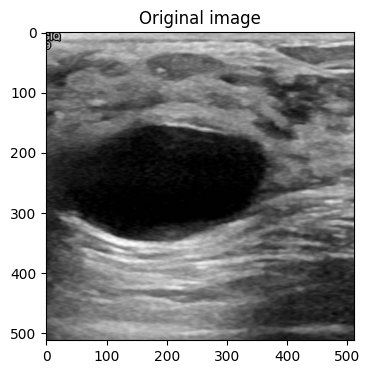

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from ingenii_quantum.hybrid_networks.qinsp_filter import QuantumInspiredImageProcessor
from importlib.resources import files

# Access the data folder
data_folder = files("ingenii_quantum.data")
image = np.array(Image.open(data_folder / 'ultrasound_image.png'))
print('Image shape:', image.shape)

fig, (ax1) = plt.subplots(1,1, figsize=(8,4))
ax1.imshow(image, cmap='gray')
ax1.set_title('Original image')
plt.show()

Let's see how this quantum-inspired filter transforms our breast ultrasound image. Through Ingenii’s library, we can customize the filter by adjusting hyperparameters like μ, p, and L, and visualize the corresponding quantum circuit. Additionally, we can select the number of iterations to apply this transformation. This means we can apply the filter multiple times, using the output image from one iteration as the input for the next. We can start by applying the quantum-inspired filter with only one iteration.

Number of iterations:  1
Selected image:  1


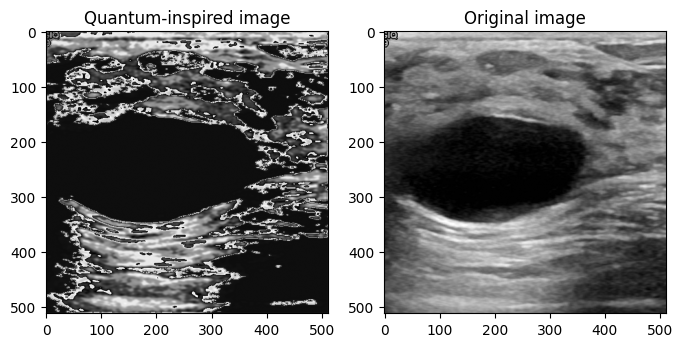

In [2]:
# Initialize the processor with desired parameters
processor = QuantumInspiredImageProcessor(mu=0.4, percentile=50, max_iter=1, L=12)

# Process the image
output_image, mae_list, image_list = processor.process(image, save=False)

# Visualize image transformation
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8,4))
ax1.imshow(output_image, cmap='gray') 
ax1.set_title('Quantum-inspired image')
ax2.imshow(image, cmap='gray')
ax2.set_title('Original image')
plt.show()

Now, let's apply the transformation for 15 epochs.

Number of iterations:  15
Selected image:  14


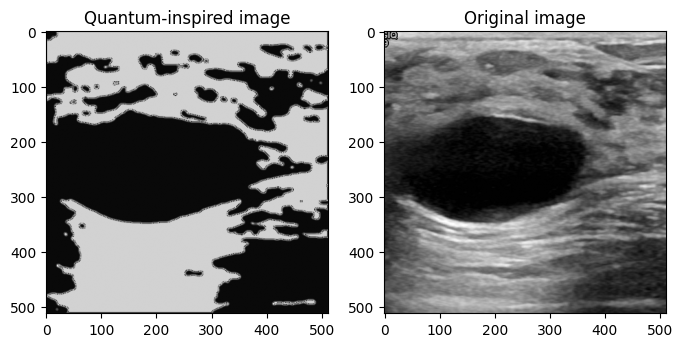

In [3]:
# Initialize the processor with desired parameters
processor = QuantumInspiredImageProcessor(mu=0.4, percentile=50, max_iter=15, L=12)

# Process the image
output_image, mae_list, image_list = processor.process(image, save=False)

# Visualize image transformation
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8,4))
ax1.imshow(output_image, cmap='gray') 
ax1.set_title('Quantum-inspired image')
ax2.imshow(image, cmap='gray')
ax2.set_title('Original image')
plt.show()

Let’s examine the quantum-inspired transformation after 1 and 15 iterations.  As we can see, for a small number of epochs, the image contains more color levels, highlighting different intensities. On the other hand, for a larger number of epochs, the image converges to a binary mask. If we use this image as an input for a predictive model rather than the final binary mask, applying the filter with just one iteration is more suitable for highlighting various potential areas of interest. Additionally, this approach is more computationally efficient.

We could also experiment by varying the number of gray levels of the image ($L$) and the steepness parameter ($\mu$), to obtain multiple variations of this quantum-inspired filter.